In [4]:
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.metrics import mean_squared_error, explained_variance_score
from numpy.linalg import inv, solve
import matplotlib.pyplot as plt
from utils_plot import *
from scipy.optimize import minimize_scalar, minimize
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics.pairwise import cosine_similarity
import json

In [5]:
# 1. Data Normalization

def preprocessing(alpha1, alpha2, N, ampl_threshold=0.1):

    targetnames = np.array(list(set(N.index) & set(alpha1.index) & set(alpha2.index)))
    print("Genes in common :", len(targetnames))

    alpha1, alpha2 = alpha1.loc[targetnames].to_numpy(), alpha2.loc[targetnames].to_numpy()
 
    ampl1 = (alpha1.max(axis=1)-alpha1.min(axis=1))/2
    ampl2 = (alpha2.max(axis=1)-alpha2.min(axis=1))/2
    ind = (ampl1 > ampl_threshold) & (ampl2 > ampl_threshold)
    alpha1, alpha2 = alpha1[ind,:], alpha2[ind,:]
    targetnames_filtered = targetnames[ind]

    N = N.loc[targetnames_filtered].to_numpy()
    
    # Identify TFs that are not present in any gene
    inactive_tfs = np.where(N.sum(axis=0) == 0)[0]
    print(f"Number of inactive TFs: {len(inactive_tfs)}")
    N = np.delete(N, inactive_tfs, axis=1)
    tf_names_filtered = np.delete(tf_names, inactive_tfs)
    
    print(f"Kept genes: {N.shape[0]} (ampl > {ampl_threshold})")
    alpha1_norm = alpha1 - np.mean(alpha1, axis=1, keepdims=True) - np.mean(alpha1, axis=0, keepdims=True) + np.mean(alpha1)
    alpha2_norm = alpha2 - np.mean(alpha2, axis=1, keepdims=True) - np.mean(alpha2, axis=0, keepdims=True) + np.mean(alpha2)
    N_norm = N - np.mean(N, axis=0, keepdims=True)

    return alpha1_norm, alpha2_norm, N_norm, targetnames_filtered, tf_names_filtered

In [6]:
def svd_regression_with_lambda_selection(alpha, N):
    """
    Perform regression using SVD and select the best regularization (lambda)
    using marginal likelihood.
    lambda1 = sigma2 (data noise) / tau2 (variance of prior on A)
    """

    # Step 1: SVD of N
    U, s, VT = np.linalg.svd(N, full_matrices=False)
    M = U.T @ alpha  # project alpha onto the SVD basis
    C = alpha.shape[1] #nb of theta

    # Step 2: Optimize variances
    def log_evidence(sigma2, tau2):
        """Compute log marginal likelihood (evidence) for given noise and prior variances."""
        #sigma2 = np.exp(sigma2)
        #tau2 = np.exp(tau2)
        denom = sigma2 + (s**2) / (sigma2/tau2)
        #denom = s**2 + lambda1  # sigma2 is absorbed
        #Term1 : penalize model complexity (if lambda is large, term is smaller)
        term1 = -0.5 * C * np.sum(np.log(denom))
        #Term2 : how well the data fit in the model. M represent the mismatch of alpha in the new basis.
        #Large M, small denominator, Bad — model should explain it well, but doesn't
        #Large M, large denominator, Okay-ish — model admits it can't explain well (high uncertainty)
        #Small M, Good — little mismatch, data aligns with prior or is close to 0
        term2 = -0.5 * np.sum((M**2) / denom[:, np.newaxis])

        residual = alpha - U @ M
        #Term3 : penalize unexplained variance (residuals)
        term3 = -0.5 * np.sum(residual**2) #/ sigma2

        return term1 + term2 + term3
    
    def neg_log_evidence(params):
        sigma2, tau2 = params
        return -log_evidence(sigma2, tau2)

    # Initial guess
    x0 = [0.1, 1e-04]

    # Bounds: sigma² and tau² must be > 0
    bounds = [(1e-3, 1e1), (1e-7, 1e-3)]
    result = minimize(neg_log_evidence, x0, method='L-BFGS-B', bounds=bounds)

    # Best params
    opt_sigma2, opt_tau2 = result.x
    max_log_evidence = -result.fun

    print(f"Optimal sigma²: {opt_sigma2:.4f}")
    print(f"Optimal tau²: {opt_tau2:.7f}")
    print(f"Maximum log marginal likelihood: {max_log_evidence:.0f}")
    
    # Step 3: Compute posterior mean (final weights A)
    #shrink = lambda_opt * s / (lambda_opt*sigma2+s**2)
    shrink = s / (s**2 + (opt_sigma2/opt_tau2)) #ISMARA (get rid of sigma2)
    X = shrink[:, np.newaxis] * M
    A_star = VT.T @ X
    
    def plot_log_evidence_surface(log_evidence_func, sigma2_range, tau2_range, n_points=30):
        sigma_vals = np.logspace(*sigma2_range, num=n_points)
        tau_vals = np.logspace(*tau2_range, num=n_points)
        S, T = np.meshgrid(sigma_vals, tau_vals)
        Z = np.zeros_like(S)

        for i in range(S.shape[0]):
            for j in range(S.shape[1]):
                Z[i, j] = log_evidence_func(S[i, j], T[i, j])

        plt.figure(figsize=(7, 5))
        cp = plt.contourf(S, T, Z, levels=30, cmap='viridis')
        plt.colorbar(cp, label='Log Marginal Likelihood')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel(r'$\sigma^2$ (data noise)')
        plt.ylabel(r'$\tau^2$ (prior variance)')
        plt.title('Log Marginal Likelihood Surface')
        plt.scatter([opt_sigma2], [opt_tau2], color='red', label='Optimum')
        plt.legend()
        plt.grid(True, which='both', ls='--', lw=0.3)
        plt.tight_layout()
        plt.show()

    plot_log_evidence_surface(log_evidence, sigma2_range=(-3, 1), tau2_range=(-7, -3), n_points=40)
    
    return A_star, opt_sigma2, opt_tau2

In [7]:
def standardize_amplitudes(matrices, target_amp=0.2):
    """
    Rescale the matrices to a single target amplitude.
    """
    standardized_matrices = []
    for matrix in matrices:
        amp = (np.max(matrix, axis=1) - np.min(matrix, axis=1)) / 2
        scale = target_amp / amp
        standardized_matrix = matrix * scale[:, np.newaxis]
        standardized_matrices.append(standardized_matrix)
    
    return standardized_matrices

(11582, 100) (11495, 100) (13568, 370)
Genes in common : 8447
Number of inactive TFs: 17
Kept genes: 542 (ampl > 0.25)
(542, 100) (542, 100) (542, 353)
Optimal sigma²: 0.0973
Optimal tau²: 0.0000253
Maximum log marginal likelihood: 21038


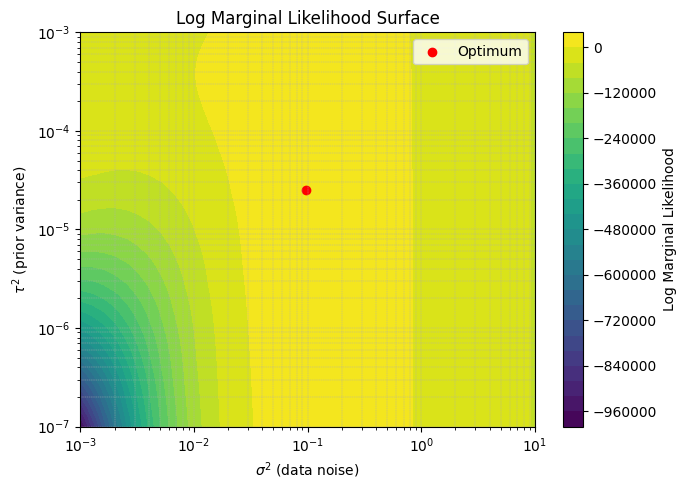

Optimal sigma²: 0.0878
Optimal tau²: 0.0000294
Maximum log marginal likelihood: 22542


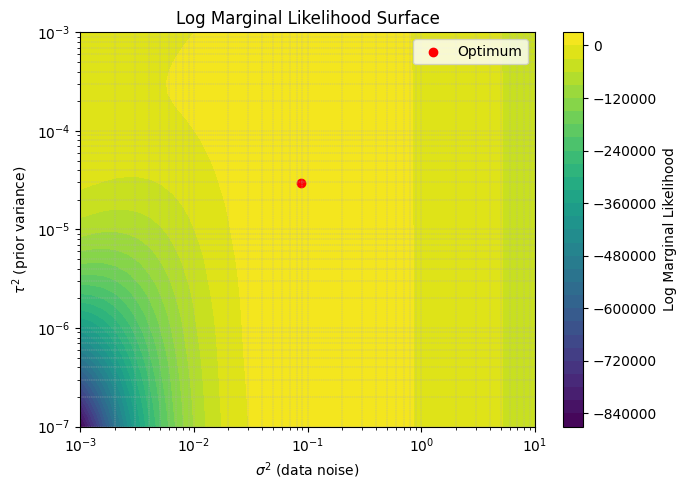

In [8]:
fileAlpha1 = "/shared/space2/molina/suttyg/alpha_snrna_rep1_5000_1_2p75.csv"
fileAlpha2 = "/shared/space2/molina/suttyg/alpha_snrna_rep2_5000_1_2p75.csv"
fileBSM = '/shared/space2/molina/suttyg/data_binding_site_matrix.txt'
process = ["transcription", "\u03B1"]
theta_smooth = np.round(np.linspace(0.01, 1.00, 100), 2)  # 100 bins from 0.01 to 1.00

N = pd.read_csv(fileBSM, sep="\t",index_col=0)
tf_names = N.columns
alpha1 = pd.read_csv(fileAlpha1, sep=",",index_col=0)
alpha2 = pd.read_csv(fileAlpha2, sep=",",index_col=0)

#Select common genes and normalize
print(alpha1.shape, alpha2.shape, N.shape)
ampl_threshold=0.25
alpha1_norm, alpha2_norm, N_norm, targetnames, tf_names = preprocessing(alpha1, alpha2, N, ampl_threshold=ampl_threshold)
print(alpha1_norm.shape, alpha2_norm.shape, N_norm.shape)

A_star, opt_sigma2, opt_tau2 = svd_regression_with_lambda_selection(alpha1_norm, N_norm)
A_star_2, opt_sigma2_2, opt_tau2_2 = svd_regression_with_lambda_selection(alpha2_norm, N_norm)

EV at optimum :
EV_train : 5.60 %
EV_test : 4.89 %


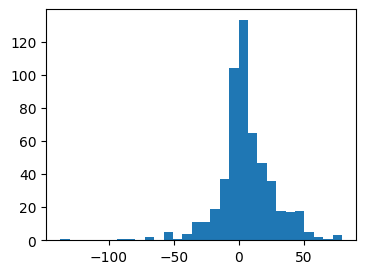

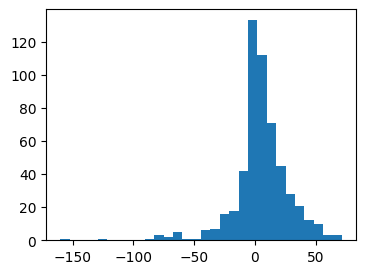

Proportion of neg gene EV : 35.79 %


In [9]:
#EV for rows (genes independant) at optimum sigma2, tau2
R = N_norm @ A_star
EVs_train = []
EVs_test = []
for k in range(R.shape[0]):
    EV_train = round(explained_variance_score(alpha1_norm[k, :], R[k, :])*100,2)#, "MSE_train :", round(mean_squared_error(alpha1_norm, R),2))
    EV_test = round(explained_variance_score(alpha2_norm[k, :], R[k, :])*100,2)#, "MSE_test :", round(mean_squared_error(alpha2_norm, R),3))
    EVs_train.append(EV_train)
    EVs_test.append(EV_test)
print("EV at optimum :")
print(f"EV_train : {np.mean(np.array(EVs_train)):.2f} %")
print(f"EV_test : {np.mean(np.array(EVs_test)):.2f} %")
plt.figure(figsize=(4, 3))
plt.hist(np.sort(EVs_train)[:], bins=30)
plt.show()
plt.figure(figsize=(4, 3))
plt.hist(np.sort(EVs_test)[:], bins=30)
plt.show()
EVs_test = np.array(EVs_test)
print(f"Proportion of neg gene EV : {len(EVs_test[EVs_test < 0])/len(EVs_test)*100:.2f} %")

In [10]:
with open('/shared/space2/molina/suttyg/gene_phase_dict.json', 'r') as f:
    d = json.load(f)
cyclic_genes = d['G1/S']+d['G2/M']
#print(cyclic_genes)

42 / 93 genes in the list.
16.52 % (proportion of pos EV : 85.71 %)



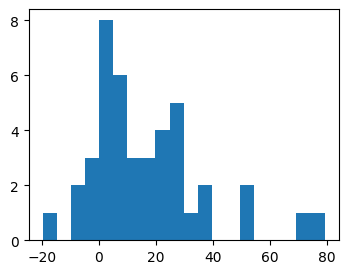

['Mcm6', 'Dtl', 'Atad2', 'Mcm4', 'Hells', 'Exo1', 'Tipin', 'Rrm2', 'Pola1', 'Nasp', 'Hmgb2', 'Ckap2', 'G2e3', 'Ncapd2', 'Ndc80', 'Nusap1', 'Ttk', 'Ccnb2', 'Cdc20', 'Kif20b', 'Cenpa', 'Aurka', 'Top2a', 'Tacc3', 'Kif11', 'Ect2', 'Cbx5', 'Hjurp', 'Cenpf', 'Bub1', 'Kif23', 'Ckap2l', 'Mki67', 'Kif2c', 'Dlgap5', 'Lbr', 'Hmmr', 'Tpx2', 'Cdca8', 'Anln', 'Cdk1', 'Cdca2']


In [11]:
#Check EV for known cyclic genes
#cyclic_genes = ["Nusap1", "Tpx2", "Kif11", "Ccnb1", "Cdk1", "Cdc20", "Top2a", "Cenpe", "Aurka", "Anln", "Prc1", "Pcna", "Mcm2", "Mcm3", "Mcm4", "Mcm5", "Mcm6", "Cdc6", "Rrm1", "Rrm2", "Ect2", "Ccne1", "Ccne2", "Cdc25a", "Chek1", "Cdc25c"]
EVs = []
c = 0
present_cyclic_genes = []
for cyclic_gene in cyclic_genes:
    try:
        n = np.where(targetnames == cyclic_gene)[0][0]
        present_cyclic_genes.append(cyclic_gene)
        EV = round(explained_variance_score(alpha1_norm[n, :], R[n, :])*100,2)
        EVs.append(EV)
    except:
        c += 1
print(len(cyclic_genes)-c, "/",len(cyclic_genes), "genes in the list.")
EVs = np.array(EVs)
print(round(np.mean(np.sort(EVs)[:]), 2), "% (proportion of pos EV :", round(np.sum(EVs > 0)/len(EVs)*100, 2), "%)\n")
plt.figure(figsize=(4, 3))
plt.hist(np.sort(EVs)[:], bins=20)
plt.show()
print(present_cyclic_genes)

23.78 %


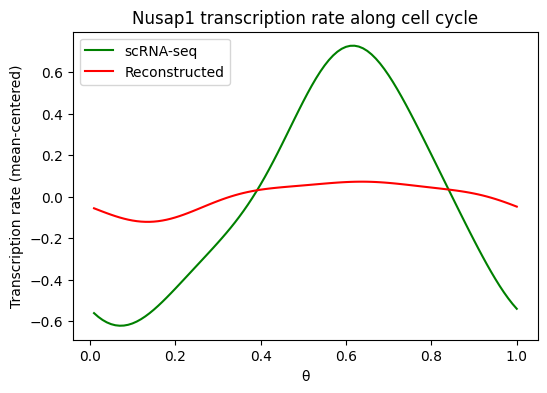

In [25]:
n = np.where(targetnames == 'Nusap1')[0][0]
#n = 30
#print("Train")
print(round(explained_variance_score(alpha1_norm[n, :], R[n, :])*100,2), "%")
plot_rate_comparison(targetnames, alpha1_norm, R, process, theta_smooth, target_nb=n)
#print("Test")
#plot_rate_comparison(targetnames, alpha2_norm, R, process, theta_smooth, target_nb=n)

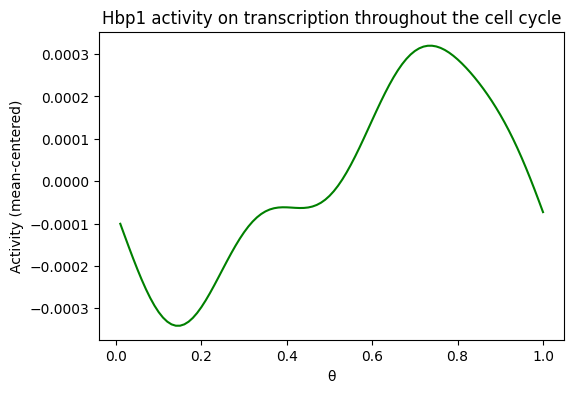

In [13]:
BP_nb = np.where(tf_names == 'Hbp1')[0][0]
#BP_nb = 30
plot_binding_protein_activity(tf_names, A_star, process, theta_smooth, BP_nb=BP_nb)

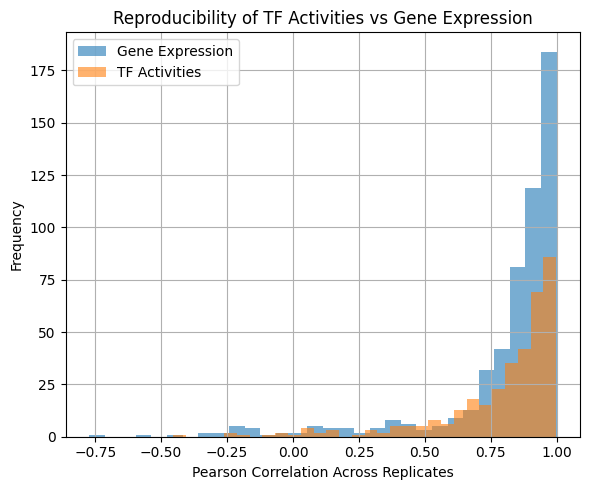

Mean correlation of expression profiles:  0.803
Mean correlation of TF activities:        0.789
Median correlation of expression:         0.897
Median correlation of TF activities:      0.88


In [14]:
def compute_reproducibility(A_star1, A_star2, alpha1_norm, alpha2_norm):
    """
    Compare reproducibility of inferred TF activities vs raw gene expression.
    
    Inputs:
        A_star1, A_star2: (TFs x theta) activity matrices from replicate 1 and 2
        alpha1_norm, alpha2_norm: (genes x theta) normalized expression data

    Outputs:
        corrs_A: Pearson correlations per TF (array of length TFs)
        corrs_E: Pearson correlations per gene (array of length genes)
    """
    n_tfs = A_star1.shape[0]
    n_genes = alpha1_norm.shape[0]

    corrs_A = np.zeros(n_tfs)
    for m in range(n_tfs):
        corrs_A[m], _ = pearsonr(A_star1[m, :], A_star2[m, :])

    corrs_E = np.zeros(n_genes)
    for g in range(n_genes):
        corrs_E[g], _ = pearsonr(alpha1_norm[g, :], alpha2_norm[g, :])

    # Plot
    plt.figure(figsize=(6, 5))
    plt.hist(corrs_E, bins=30, alpha=0.6, label='Gene Expression', color='tab:blue')
    plt.hist(corrs_A, bins=30, alpha=0.6, label='TF Activities', color='tab:orange')
    plt.xlabel('Pearson Correlation Across Replicates')
    plt.ylabel('Frequency')
    plt.title('Reproducibility of TF Activities vs Gene Expression')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print stats
    print("Mean correlation of expression profiles: ", round(np.mean(corrs_E), 3))
    print("Mean correlation of TF activities:       ", round(np.mean(corrs_A), 3))
    print("Median correlation of expression:        ", round(np.median(corrs_E), 3))
    print("Median correlation of TF activities:     ", round(np.median(corrs_A), 3))

    return corrs_A, corrs_E

corrs_A, corrs_E = compute_reproducibility(A_star, A_star_2, alpha1_norm, alpha2_norm)

In [15]:
def plot_tf_activity_profiles(A1, A2, tf_names, selected_tfs):
    """
    Plots activity profiles across θ for selected TFs.
    
    selected_tfs: list of TF names to plot (must be in tf_names)
    """
    tf_to_idx = {name: i for i, name in enumerate(tf_names)}

    plt.figure(figsize=(10, len(selected_tfs) * 2.5))

    for idx, tf in enumerate(selected_tfs, 1):
        i = tf_to_idx[tf]
        plt.subplot(len(selected_tfs), 1, idx)
        plt.plot(theta_smooth, A1[i, :], label='Dataset 1', color='tab:blue')
        plt.plot(theta_smooth, A2[i, :], label='Dataset 2', color='tab:orange')
        plt.title(f'TF: {tf}')
        plt.xlabel('Theta')
        plt.ylabel('Activity')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

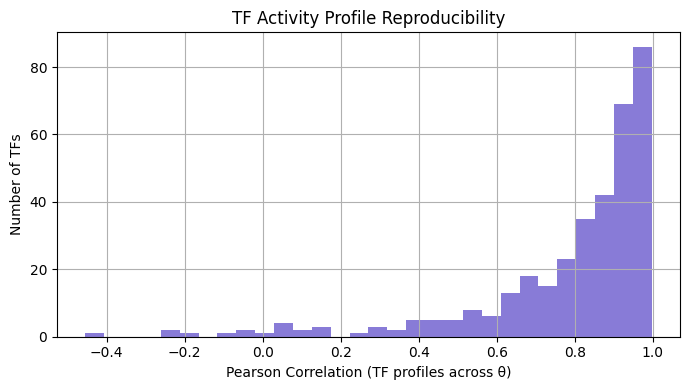


🔻 Most Diverging TFs:
Sox11: r = -0.455
Tfcp2l1: r = -0.253
Sox30: r = -0.235
Msx1_Lhx9_Barx1_Rax_Dlx6: r = -0.194
Fosb: r = -0.091
Bcl6: r = -0.066
Spic: r = -0.031
Pou3f4: r = -0.011
Smad1: r = 0.054
Arid3a: r = 0.074

🔺 Most Stable TFs:
Junb_Jund: r = 0.997
Hsf4: r = 0.995
Nfe2l2: r = 0.994
Gli2: r = 0.991
Gli3_Zic1: r = 0.990
Cxxc1: r = 0.989
Ybx1_Nfya_Nfyb_Nfyc_Cebpz: r = 0.987
Crem_Jdp2: r = 0.987
Hoxa5: r = 0.987
Hcfc1_Six5: r = 0.987


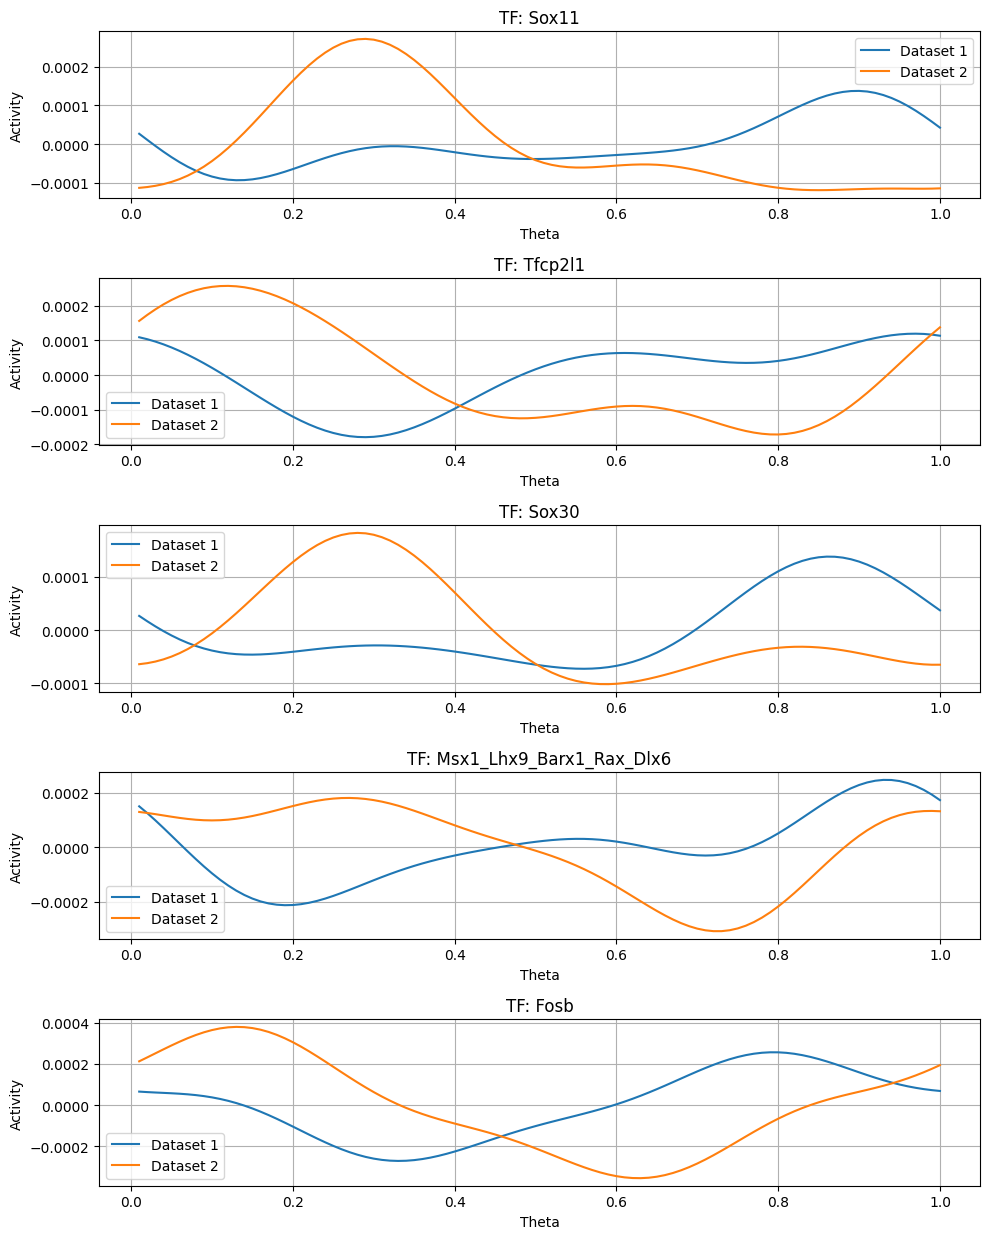

In [16]:
def compute_tf_profile_correlations(A1, A2, tf_names=None, top_n=20):
    """
    Compute per-TF Pearson correlation between activity profiles (across θ).
    
    Returns:
        - corrs: array of correlation values
        - diverging_tfs: indices of low-correlation TFs
        - stable_tfs: indices of high-correlation TFs
    """

    assert A1.shape == A2.shape, "A1 and A2 must have the same shape"
    n_tfs = A1.shape[0]
    corrs = np.zeros(n_tfs)

    for i in range(n_tfs):
        corrs[i], _ = pearsonr(A1[i, :], A2[i, :])

    # Sort indices
    diverging_idx = np.argsort(corrs)[:top_n]
    stable_idx = np.argsort(corrs)[-top_n:][::-1]

    # Plot histogram
    plt.figure(figsize=(7, 4))
    plt.hist(corrs, bins=30, color='slateblue', alpha=0.8)
    plt.xlabel('Pearson Correlation (TF profiles across θ)')
    plt.ylabel('Number of TFs')
    plt.title('TF Activity Profile Reproducibility')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    if tf_names is not None:
        print("\n🔻 Most Diverging TFs:")
        for i in diverging_idx:
            print(f"{tf_names[i]}: r = {corrs[i]:.3f}")
        print("\n🔺 Most Stable TFs:")
        for i in stable_idx:
            print(f"{tf_names[i]}: r = {corrs[i]:.3f}")

    return corrs, diverging_idx, stable_idx

corrs, diverging, stable = compute_tf_profile_correlations(A_star, A_star_2, tf_names, top_n=10)

plot_tf_activity_profiles(A_star, A_star_2, tf_names, [tf_names[i] for i in diverging[:5]])
#plot_tf_activity_profiles(A_star, A_star_2, tf_names, [tf_names[i] for i in stable[:5]])

In [17]:
def plot_activity_difference_heatmap(A1, A2, tf_names=None, top_n=10):
    """
    Plots a heatmap of the top n differentially active TFs across θ.
    
    A1, A2: TF x theta activity matrices
    tf_names: list of TF names (optional)
    """
    assert A1.shape == A2.shape, "Shape mismatch between activity matrices"
    delta_A = A1 - A2  # shape: TF x theta

    # Select top N TFs by mean absolute difference
    diff_score = np.mean(np.abs(delta_A), axis=1)
    top_indices = np.argsort(diff_score)[-top_n:]

    delta_top = delta_A[top_indices, :]
    row_labels = [tf_names[i] if tf_names is not None else f"TF_{i}" for i in top_indices]

    plt.figure(figsize=(10, 0.3 * top_n + 2))
    sns.heatmap(delta_top, cmap="vlag", center=0, xticklabels=theta_smooth, yticklabels=row_labels)
    plt.title(f'TF Activity Differences (Dataset 1 - Dataset 2)\nTop {top_n} TFs')
    plt.xlabel('Theta')
    plt.ylabel('TF')
    plt.tight_layout()
    plt.show()
    
# Heatmap of top 30 changing TFs
#plot_activity_difference_heatmap(A_star, A_star_2, tf_names, top_n=10)

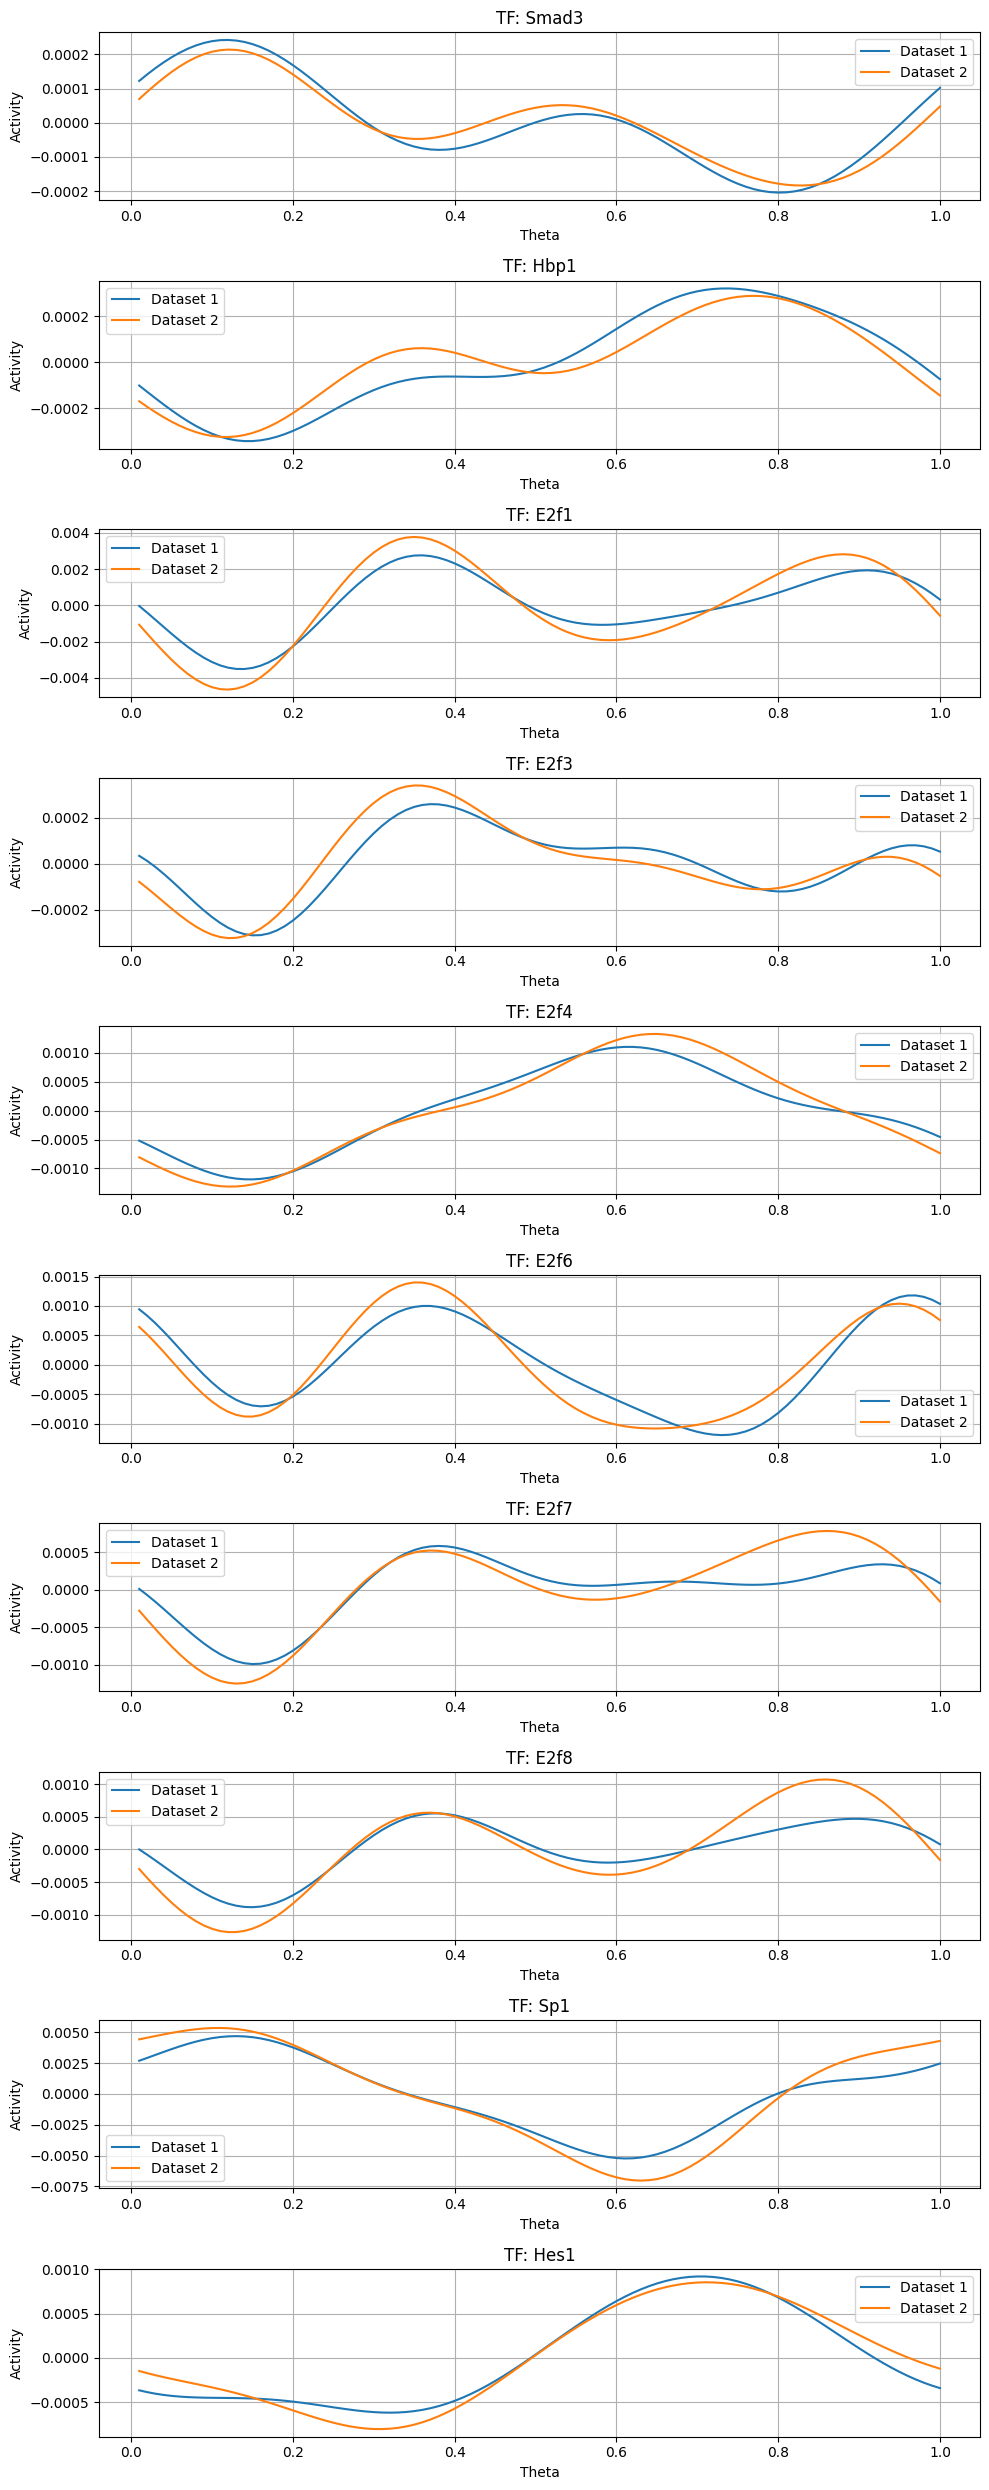

In [18]:
# Line plots for specific TFs of interest
plot_tf_activity_profiles(A_star, A_star_2, tf_names, selected_tfs=["Smad3", "Hbp1", "E2f1", "E2f3", "E2f4", "E2f6", "E2f7", "E2f8", "Sp1", "Hes1"])

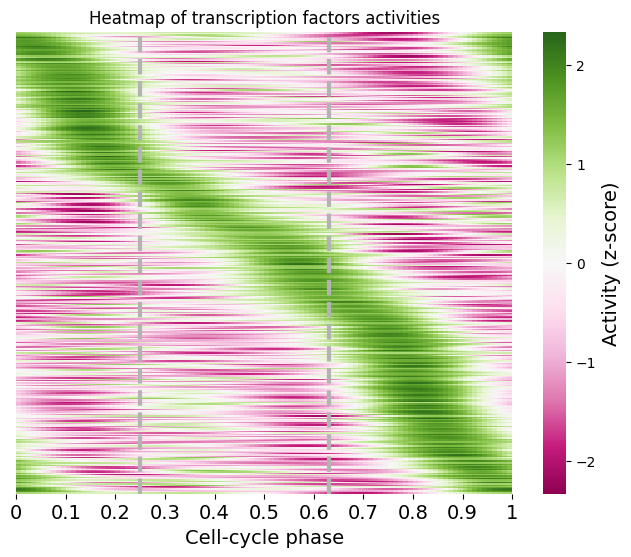

In [19]:
#Heatmap of BPs activity along cell cycle
tf_displayed = plot_heatmap(A_star, cmap='PiYG')
#tf_displayed = plot_heatmap(A, ylabels=tf_names, display_limit=25)
#print(tf_displayed)

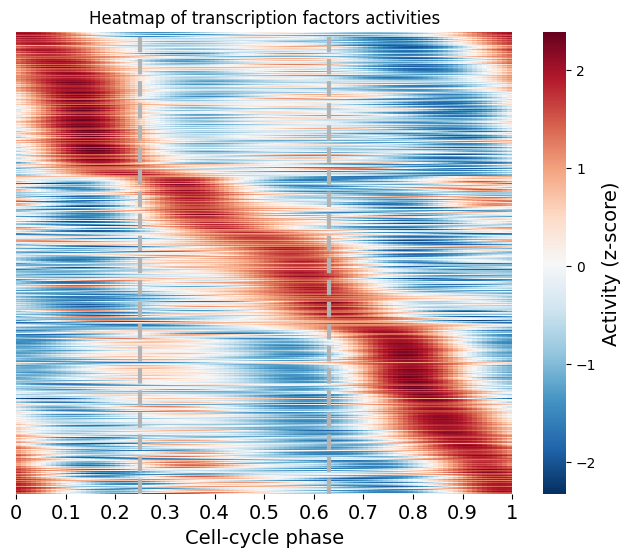

In [20]:
#Heatmap of BPs activity along cell cycle
gene_displayed = plot_heatmap(alpha1_norm)
#print(tf_displayed)

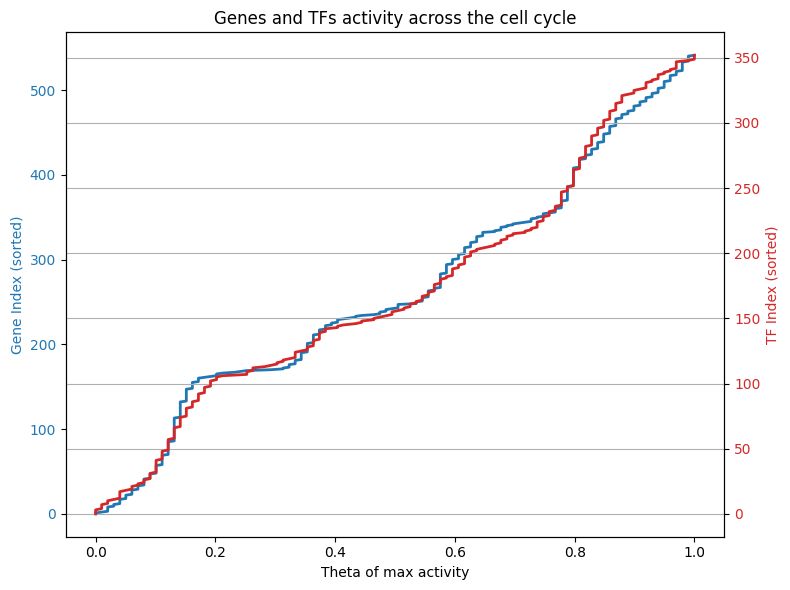

In [21]:
plot_peak_theta_vs_index(alpha1_norm, A_star)

In [22]:
expected_activity = {
    "Smad3": {"ranges": [(0.1, 0.4)], "inhibitory": True},
    "Hbp1": {"ranges": [(0.1, 0.4)], "inhibitory": True},
    "E2f1": {"ranges": [(0.1, 0.4)], "inhibitory": False},
    "E2f2_E2f5": {"ranges": [(0.1, 0.4)], "inhibitory": False},
    "E2f3": {"ranges": [(0.1, 0.4)], "inhibitory": False},
    "E2f4": {"ranges": [(0.01, 0.25)], "inhibitory": False}, #May be True
    "E2f6": {"ranges": [(0.01, 0.25), (0.63, 0.9)], "inhibitory": False}, #May be True
    "E2f7": {"ranges": [(0.4, 0.9)], "inhibitory": False}, #May be True
    "E2f8": {"ranges": [(0.4, 0.9)], "inhibitory": False}, #May be True
    "Sp1": {"ranges": [(0.1, 0.63)], "inhibitory": False},
    "Hes1": {"ranges": [(0.1, 0.4)], "inhibitory": True},
    #"Elf3": {"ranges": [(0.25, 1)], "inhibitory": False},
    #"Tfap4": {"ranges": [(0.63, 0.9)], "inhibitory": False}
}

In [23]:
key_tfs = ["Smad3", "Hbp1", "E2f1", "E2f2", "E2f3", "E2f4", "E2f5", "E2f6", "E2f7", "E2f8", "Sp1", "Hes1"]

fileAlphaTF_sn1 = "/shared/space2/molina/suttyg/alpha_snrna_rep1_5000_1_2p75.csv"
fileAlphaTF_sn2 = "/shared/space2/molina/suttyg/alpha_snrna_rep2_5000_1_2p75.csv"

#Get spliced RNA data to compare splicing and protein activity dynamics
alpha_sn1 = pd.read_csv(fileAlphaTF_sn1, sep=",",index_col=0)
alpha_sn2 = pd.read_csv(fileAlphaTF_sn2, sep=",",index_col=0)

tf_names_filtered = np.array([tf for tf in key_tfs if tf in alpha_sn1.index and tf in alpha_sn2.index and tf in tf_names])
print("TFs in common :", str(len(tf_names_filtered))+"/"+str(len(key_tfs)))

alpha_sn1_f, alpha_sn2_f = alpha_sn1.loc[tf_names_filtered], alpha_sn2.loc[tf_names_filtered]
alpha_sn1_n, alpha_sn2_n = alpha_sn1_f.to_numpy(), alpha_sn2_f.to_numpy()

#Standardize amplitudes
#A_standard = A_standard - np.mean(A_standard, axis=1, keepdims=True)
alpha_sn_n = (alpha_sn1_n + alpha_sn2_n) / 2
alpha_sn_norm = alpha_sn_n - np.mean(alpha_sn_n, axis=1, keepdims=True) - np.mean(alpha_sn_n, axis=0, keepdims=True) + np.mean(alpha_sn_n)
alpha_sn_norm, A_standard = standardize_amplitudes([alpha_sn_norm, A_star])

TFs in common : 10/12


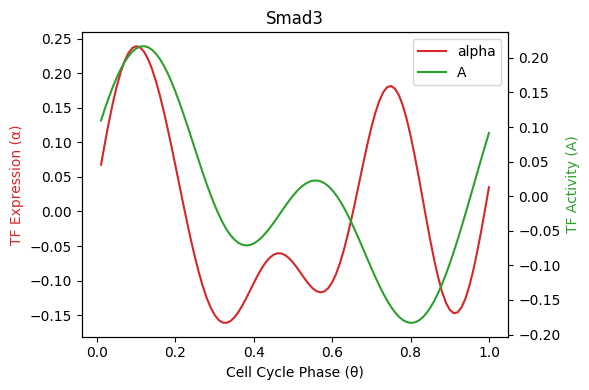

scRNA & A correlation : -0.261 (inhibitor)

Expected activity range : [(0.1, 0.4)]
TF activity biological z-score : -7.15 (inhibitor)


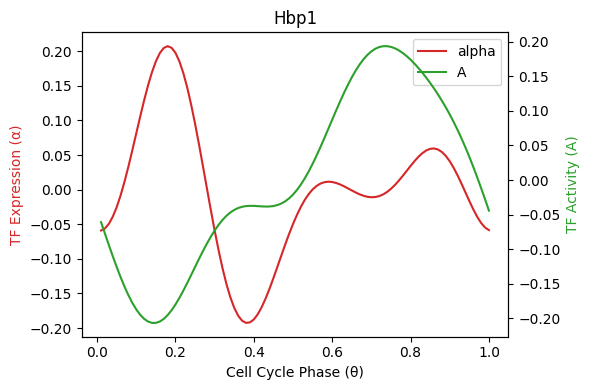

scRNA & A correlation : 0.129 (inhibitor)

Expected activity range : [(0.1, 0.4)]
TF activity biological z-score : 16.10 (inhibitor)


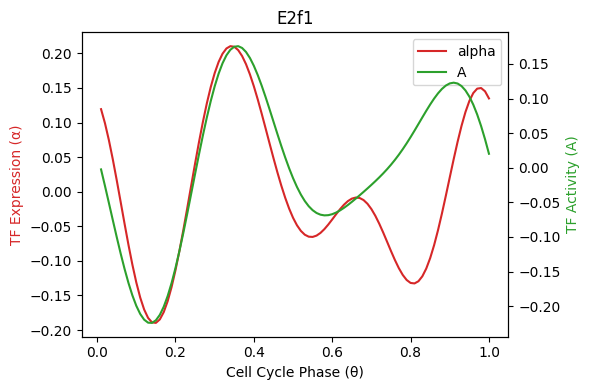

scRNA & A correlation : 0.676 (activator)

Expected activity range : [(0.1, 0.4)]
TF activity biological z-score : -0.95 (activator)


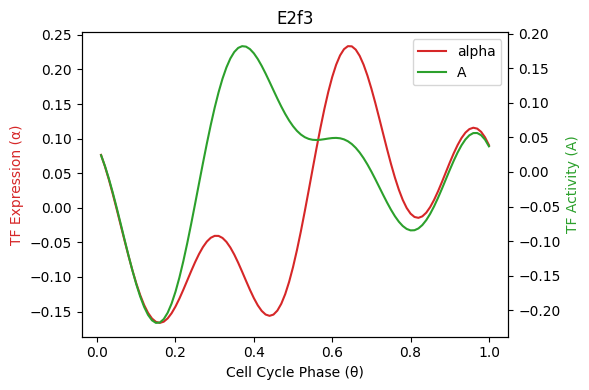

scRNA & A correlation : 0.123 (activator)

Expected activity range : [(0.1, 0.4)]
TF activity biological z-score : -0.99 (activator)


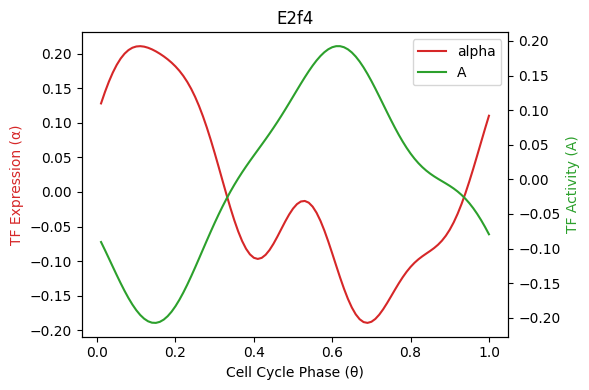

scRNA & A correlation : -0.839 (activator)

Expected activity range : [(0.01, 0.25)]
TF activity biological z-score : -17.07 (activator)


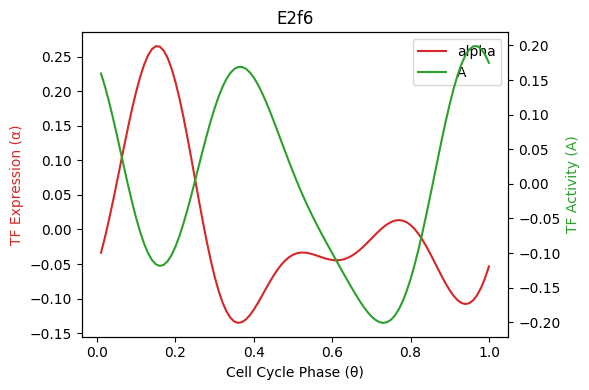

scRNA & A correlation : -0.661 (activator)

Expected activity range : [(0.01, 0.25), (0.63, 0.9)]
TF activity biological z-score : -7.85 (activator)


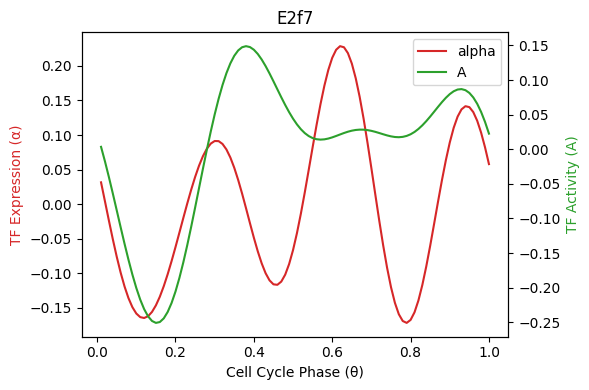

scRNA & A correlation : 0.299 (activator)

Expected activity range : [(0.4, 0.9)]
TF activity biological z-score : 4.52 (activator)


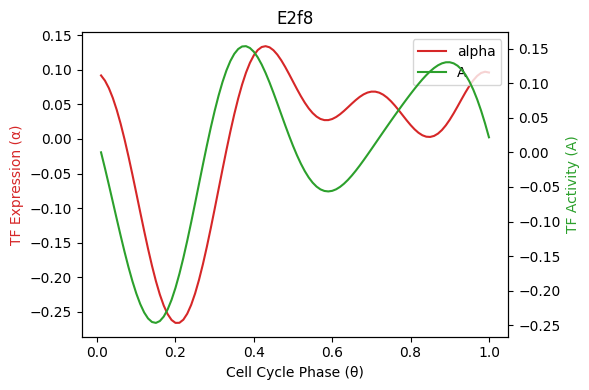

scRNA & A correlation : 0.493 (activator)

Expected activity range : [(0.4, 0.9)]
TF activity biological z-score : 3.44 (activator)


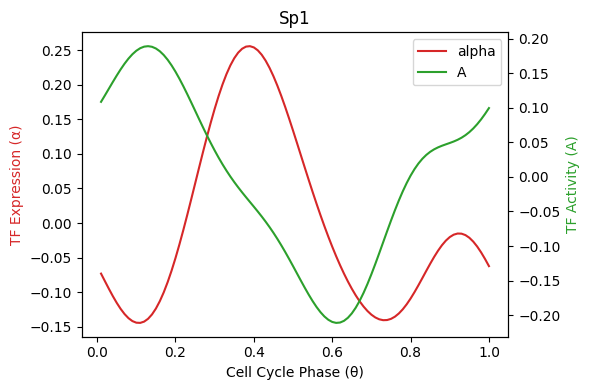

scRNA & A correlation : -0.274 (activator)

Expected activity range : [(0.1, 0.63)]
TF activity biological z-score : -0.92 (activator)


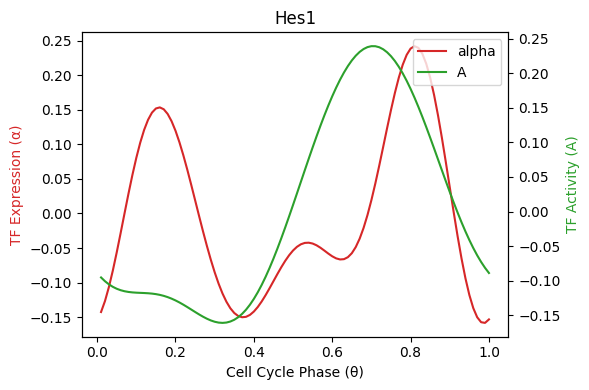

scRNA & A correlation : -0.316 (inhibitor)

Expected activity range : [(0.1, 0.4)]
TF activity biological z-score : 17.63 (inhibitor)
Global correlation :-0.063
Global z-score :0.68


In [24]:
corrs = []
z_vals = []
for tf in range(len(tf_names_filtered)):
    plot_TF_exp_activity(theta_smooth, alpha_sn_norm, A_standard, tf_names, tf_names_filtered, tf)
    corr = spearmanr(alpha_sn_norm[tf], A_standard[list(tf_names).index(tf_names_filtered[tf])])[0]
    action = "activator" if not expected_activity[tf_names_filtered[tf]]["inhibitory"] else "inhibitor"
    if (action == "inhibitor"):
        corr = -corr
    print(f"scRNA & A correlation : {corr:.3f} ({ action })\n")
    z_val = compute_tf_activity_difference(A_standard[list(tf_names).index(tf_names_filtered[tf]), :], theta_smooth, expected_activity[tf_names_filtered[tf]]["ranges"], expected_activity[tf_names_filtered[tf]]["inhibitory"])
    corrs.append(corr)
    z_vals.append(z_val)
    print(f"Expected activity range : {expected_activity[tf_names_filtered[tf]]["ranges"]}")
    print(f"TF activity biological z-score : {z_val:.2f} ({ action })")
print(f"Global correlation :{np.mean(corrs):.3f}")
print(f"Global z-score :{np.mean(z_vals):.2f}")